In [45]:
# ==========================================================
# BLOCCO 1: Data Cleaning e Aggregazione ottimizzato (ZeekDataFall22)
# ==========================================================

import os
import glob
import pandas as pd
from tqdm import tqdm

# Percorso cartella parquet
folder_path = r"C:\Users\maria\Desktop\Zeek_ML\UWF-ZeekDataFall22"
parquet_files = glob.glob(os.path.join(folder_path, "*.parquet"))

# -----------------------
# 1️⃣ Caricamento incrementale
# -----------------------
dfs = []
for file in tqdm(parquet_files, desc="Caricamento file parquet"):
    dfs.append(pd.read_parquet(file))
data = pd.concat(dfs, ignore_index=True)
print(f"Totale righe iniziali: {len(data)}")
print(f"Totale colonne iniziali: {data.shape[1]}")

# -----------------------
# 2️⃣ Conversione object → category per risparmio RAM
# -----------------------
for col in data.select_dtypes(include=['object']).columns:
    data[col] = data[col].astype('category')

# -----------------------
# 3️⃣ Analisi valori mancanti
# -----------------------
col_summary = pd.DataFrame({
    'dtype': data.dtypes,
    'num_missing': data.isna().sum(),
    'perc_missing': data.isna().mean() * 100
}).sort_values('perc_missing', ascending=False)
display(col_summary)

# -----------------------
# 4️⃣ Eliminazione colonne con troppi NaN (>50%)
# -----------------------
threshold = 50
cols_to_drop = col_summary[col_summary['perc_missing'] > threshold].index.tolist()
if cols_to_drop:
    data.drop(columns=cols_to_drop, inplace=True)
    print(f"Colonne eliminate per troppi NaN (> {threshold}%): {cols_to_drop}")
else:
    print("Nessuna colonna da eliminare per troppi NaN.")

# -----------------------
# 5️⃣ Rimozione duplicati (solo colonne chiave per risparmio RAM)
# -----------------------
subset_cols = ['uid', 'ts', 'orig_bytes', 'resp_bytes'] if 'uid' in data.columns else None
duplicates_before = data.duplicated(subset=subset_cols).sum()
data = data.drop_duplicates(subset=subset_cols)
print(f"Duplicati rimossi: {duplicates_before}")

# -----------------------
# 6️⃣ Imputazione valori mancanti
# -----------------------
num_cols = data.select_dtypes(include=['int64','float64']).columns
cat_cols = data.select_dtypes(include=['category']).columns

for col in num_cols:
    if data[col].isna().any():
        data[col].fillna(data[col].mean(), inplace=True)
for col in cat_cols:
    if data[col].isna().any():
        mode_val = data[col].mode()
        data[col].fillna(mode_val[0] if not mode_val.empty else 'unknown', inplace=True)

# -----------------------
# 7️⃣ Aggregazioni session-level features
# -----------------------
if 'uid' not in data.columns:
    data['uid'] = range(len(data))

session_features = data.groupby('uid').agg(
    total_orig_bytes=('orig_bytes', 'sum'),
    total_resp_bytes=('resp_bytes', 'sum'),
    total_orig_pkts=('orig_pkts', 'sum'),
    total_resp_pkts=('resp_pkts', 'sum'),
    mean_duration=('duration', 'mean')
).reset_index()

data = pd.merge(data, session_features, on='uid', how='left')
print(f"Totale sessioni aggregate: {session_features.shape[0]}")

# -----------------------
# 8️⃣ Anteprima finale
# -----------------------
display(data.head())
print("✅ Data Cleaning e Aggregazioni completati.")

data.reset_index(drop=True, inplace=True)



Caricamento file parquet: 100%|██████████| 13/13 [00:00<00:00, 20.91it/s]


Totale righe iniziali: 700340
Totale colonne iniziali: 25


,dtype,num_missing,perc_missing
service,category,317407,45.321844
duration,float64,317051,45.271011
orig_bytes,float64,317051,45.271011
resp_bytes,float64,317051,45.271011
history,category,8206,1.171717
community_id,category,0,0.000000
proto,category,0,0.000000
label_technique,category,0,0.000000
label_tactic,category,0,0.000000
datetime,datetime64[ns],0,0.000000


Nessuna colonna da eliminare per troppi NaN.
Duplicati rimossi: 39967


C:\Users\maria\AppData\Local\Temp\ipykernel_14136\558843203.py:79: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  session_features = data.groupby('uid').agg(


Totale sessioni aggregate: 660373


,community_id,conn_state,duration,history,src_ip_zeek,src_port_zeek,dest_ip_zeek,dest_port_zeek,local_orig,local_resp,...,uid,datetime,label_tactic,label_technique,label_binary,total_orig_bytes,total_resp_bytes,total_orig_pkts,total_resp_pkts,mean_duration
0,1:ktX8uiwrFpzrBHnE1G51yTAiiQo=,S1,41.878964,ShAdD,143.88.10.11,42296,143.88.10.13,9999,False,False,...,CrA3emsiAM5XvugO6,2022-10-23 22:07:45.793,Persistence,T1546,True,11.0,1847.0,7,5,41.878964
1,1:52yAKDtnHSPDIljwNPlA+UWODdA=,SF,0.041849,ShAdDFaf,143.88.10.11,57042,143.88.10.16,9999,False,False,...,CqO92B3QWHYhyPdtse,2022-10-05 18:14:34.531,Execution,T1059,True,114.0,73.0,9,6,0.041849
2,1:CLE/zfbKMSEi1spOm7y0JJKUgO4=,SF,0.046801,ShAdDFaf,143.88.10.11,57044,143.88.10.16,9999,False,False,...,CPwSIpstvV2fZBc4k,2022-10-05 18:14:51.275,Execution,T1059,True,1014.0,73.0,9,6,0.046801
3,1:TTpmQx1wKxVI3KmlIDAsdr/5rXg=,S1,0.012059,ShAdDa,143.88.10.11,57046,143.88.10.16,9999,False,False,...,Cy4bYOmyBBGRSvod9,2022-10-05 18:14:57.059,Execution,T1059,True,3008.0,51.0,6,3,0.012059
4,1:VhB7MbbJ52hjItNqXYgI9n8660Q=,SF,0.013730,Dd,143.88.20.12,68,143.88.20.1,67,False,False,...,CMcgot3HfOuCDV3s11,2022-10-04 11:40:45.900,Collection,T1557,True,600.0,600.0,2,2,0.013730


✅ Data Cleaning e Aggregazioni completati.


⚠️ Campioni benigni rilevati: 350339 / 660373 (53.05%)


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


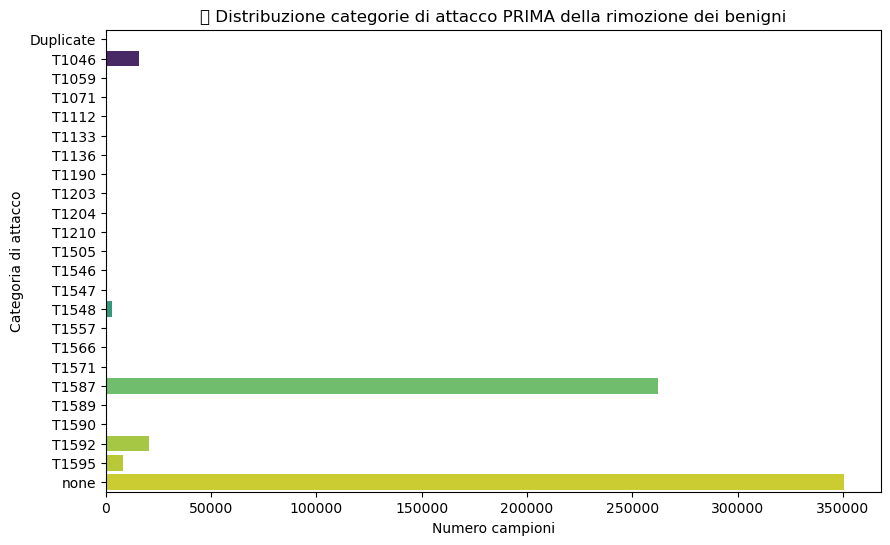

✅ Dopo rimozione benigni: 310034 righe rimanenti.

📊 Distribuzione aggiornata per categorie di attacco (solo attacchi, benigni rimossi):


,Conteggio,Percentuale (%)
label_technique,,
T1587,262409,84.64
T1592,20382,6.57
T1046,16020,5.17
T1595,8104,2.61
T1548,2893,0.93
T1589,135,0.04
T1590,40,0.01
T1071,12,0.00
T1566,9,0.00


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


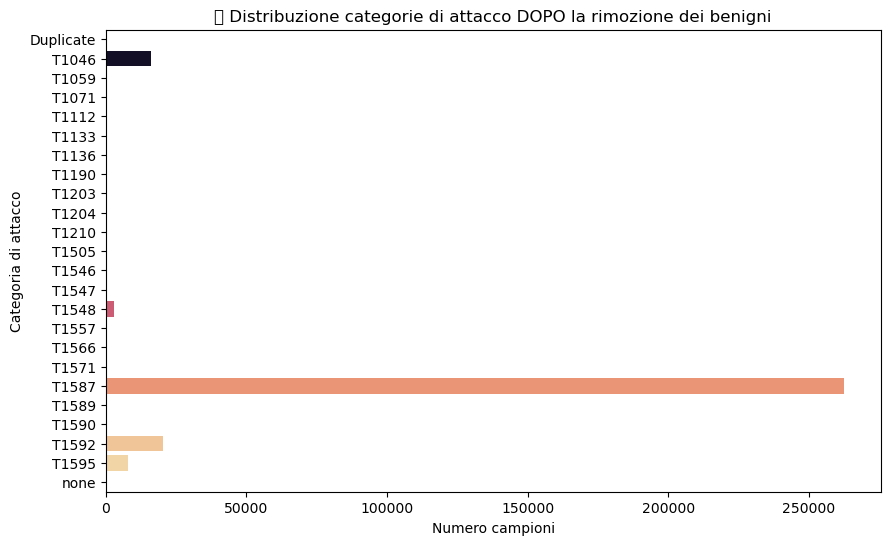

In [46]:
# ==========================================================
# BLOCCO 2: Rimozione traffico benigno ("none") per multiclasse
# ==========================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Controllo colonna obbligatoria
if 'label_technique' not in data.columns:
    raise KeyError("⚠️ Manca la colonna 'label_technique' nel dataset caricato.")

# ----- Prima della rimozione -----
total_count = len(data)
none_count = (data['label_technique'] == 'none').sum()
print(f"⚠️ Campioni benigni rilevati: {none_count} / {total_count} ({none_count/total_count*100:.2f}%)")

# Grafico prima della rimozione
attack_counts_before = data['label_technique'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(y=attack_counts_before.index, x=attack_counts_before.values, palette='viridis')
plt.title("📊 Distribuzione categorie di attacco PRIMA della rimozione dei benigni")
plt.xlabel("Numero campioni")
plt.ylabel("Categoria di attacco")
plt.show()

# ----- Rimozione benigni -----
data = data[data['label_technique'] != 'none'].reset_index(drop=True)
print(f"✅ Dopo rimozione benigni: {len(data)} righe rimanenti.")

# ----- Dopo la rimozione -----
attack_counts_after = data['label_technique'].value_counts().sort_values(ascending=False)
attack_percent_after = (attack_counts_after / len(data) * 100).round(2)
attack_df_after = pd.DataFrame({
    'Conteggio': attack_counts_after,
    'Percentuale (%)': attack_percent_after
})
print("\n📊 Distribuzione aggiornata per categorie di attacco (solo attacchi, benigni rimossi):")
display(attack_df_after)

plt.figure(figsize=(10,6))
sns.barplot(y=attack_counts_after.index, x=attack_counts_after.values, palette='magma')
plt.title("📊 Distribuzione categorie di attacco DOPO la rimozione dei benigni")
plt.xlabel("Numero campioni")
plt.ylabel("Categoria di attacco")
plt.show()

# ----- Aggiornamento tactic -----
if 'tactic' in data.columns:
    tactic_counts_after = data['tactic'].value_counts().sort_values(ascending=False)
    tactic_percent_after = (tactic_counts_after / len(data) * 100).round(2)
    tactic_df_after = pd.DataFrame({
        'Conteggio': tactic_counts_after,
        'Percentuale (%)': tactic_percent_after
    })
    print("\n📊 Distribuzione aggiornata per tactic (benigni rimossi):")
    display(tactic_df_after)


In [47]:
# ==========================================================
# BLOCCO 3a: Controllo valori nulli e riepilogo colonne/feature
# ==========================================================
assert 'data' in locals(), "⚠️ Il DataFrame 'data' non è definito: esegui prima i blocchi precedenti."

# Controllo valori nulli residui
null_counts = data.isna().sum()
null_cols = null_counts[null_counts > 0]
if len(null_cols) == 0:
    print("✅ Non ci sono valori nulli residui.")
else:
    print("⚠️ Colonne con valori nulli residui:")
    display(null_cols)

# Riepilogo colonne e feature rimaste dopo data cleaning e aggregazioni
print("\n📊 Colonne e feature disponibili per l'analisi:")
for i, col in enumerate(data.columns):
    print(f"{i+1}. {col}")

# Opzionale: possiamo separare feature numeriche e categoriali per la fase successiva
num_features = data.select_dtypes(include=['int64','float64']).columns.tolist()
cat_features = data.select_dtypes(include=['object','category']).columns.tolist()

print("\n🔹 Feature numeriche:")
print(num_features)
print("\n🔹 Feature categoriali:")
print(cat_features)
# --------------------------
# Salvataggio feature categoriali
# --------------------------
cat_features_df = data[cat_features].copy()
cat_features_df.to_parquet(r"C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22\categorical_features.parquet", index=False)
print(f"💾 Feature categoriali salvate: {cat_features_df.shape[1]} colonne, {cat_features_df.shape[0]} righe")


✅ Non ci sono valori nulli residui.

📊 Colonne e feature disponibili per l'analisi:
1. community_id
2. conn_state
3. duration
4. history
5. src_ip_zeek
6. src_port_zeek
7. dest_ip_zeek
8. dest_port_zeek
9. local_orig
10. local_resp
11. missed_bytes
12. orig_bytes
13. orig_ip_bytes
14. orig_pkts
15. proto
16. resp_bytes
17. resp_ip_bytes
18. resp_pkts
19. service
20. ts
21. uid
22. datetime
23. label_tactic
24. label_technique
25. label_binary
26. total_orig_bytes
27. total_resp_bytes
28. total_orig_pkts
29. total_resp_pkts
30. mean_duration

🔹 Feature numeriche:
['duration', 'src_port_zeek', 'dest_port_zeek', 'missed_bytes', 'orig_bytes', 'orig_ip_bytes', 'orig_pkts', 'resp_bytes', 'resp_ip_bytes', 'resp_pkts', 'ts', 'total_orig_bytes', 'total_resp_bytes', 'total_orig_pkts', 'total_resp_pkts', 'mean_duration']

🔹 Feature categoriali:
['community_id', 'conn_state', 'history', 'src_ip_zeek', 'dest_ip_zeek', 'proto', 'service', 'uid', 'label_tactic', 'label_technique', 'label_binary']
💾 F

✅ Feature con varianza significativa: ['ts', 'dest_port_zeek', 'src_port_zeek', 'resp_ip_bytes', 'orig_ip_bytes', 'resp_bytes', 'total_resp_bytes', 'orig_bytes', 'total_orig_bytes', 'missed_bytes', 'resp_pkts', 'total_resp_pkts', 'orig_pkts', 'total_orig_pkts', 'duration', 'mean_duration']
⚠️ Numero di outlier trovati per feature:


ts                  47722
dest_port_zeek          0
src_port_zeek           2
resp_ip_bytes       22952
orig_ip_bytes       47855
resp_bytes          23902
total_resp_bytes    23902
orig_bytes          23902
total_orig_bytes    23902
missed_bytes            8
resp_pkts           22952
total_resp_pkts     22952
orig_pkts           23741
total_orig_pkts     23741
duration            23902
mean_duration       23902
dtype: int64

🏗️ Applicazione trasformazioni per gestire outlier...


📄 REPORT FINALE - Dataset post Winsorization + log

🔹 Statistiche descrittive:


,count,mean,std,min,25%,50%,75%,max
ts,310034.0,2.123226e+01,0.000273,2.123128e+01,2.123236e+01,2.123236e+01,2.123236e+01,2.123236e+01
dest_port_zeek,310034.0,9.471707e+00,1.941075,3.988984e+00,9.084891e+00,1.021709e+01,1.074712e+01,1.107874e+01
src_port_zeek,310034.0,1.079624e+01,0.114324,1.050206e+01,1.069612e+01,1.077306e+01,1.090436e+01,1.099638e+01
resp_ip_bytes,310034.0,4.380596e-01,1.554144,9.999995e-07,9.999995e-07,9.999995e-07,9.999995e-07,6.734592e+00
orig_ip_bytes,310034.0,3.923842e+00,0.451445,3.713572e+00,3.806662e+00,3.806662e+00,3.806662e+00,6.357842e+00
resp_bytes,310034.0,4.634506e+00,0.297487,4.556757e+00,4.556757e+00,4.556757e+00,4.556757e+00,6.437752e+00
total_resp_bytes,310034.0,4.634506e+00,0.297487,4.556757e+00,4.556757e+00,4.556757e+00,4.556757e+00,6.437752e+00
orig_bytes,310034.0,4.781767e+00,0.148683,4.477337e+00,4.774184e+00,4.774184e+00,4.774184e+00,6.013715e+00
total_orig_bytes,310034.0,4.781767e+00,0.148683,4.477337e+00,4.774184e+00,4.774184e+00,4.774184e+00,6.013715e+00
missed_bytes,310034.0,9.999995e-07,0.000000,9.999995e-07,9.999995e-07,9.999995e-07,9.999995e-07,9.999995e-07



📝 Motivazione trasformazione:
- Alcune feature avevano outlier estremi che potevano distorcere le distribuzioni.
- Winsorization: limita i valori ai percentili 1% e 99%, riducendo l'impatto degli outlier.
- Log-transform: riduce l'asimmetria e migliora la stabilità numerica.
- Il dataset risultante ha distribuzioni più compatte e valori pronti per scaling/normalizzazione.


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

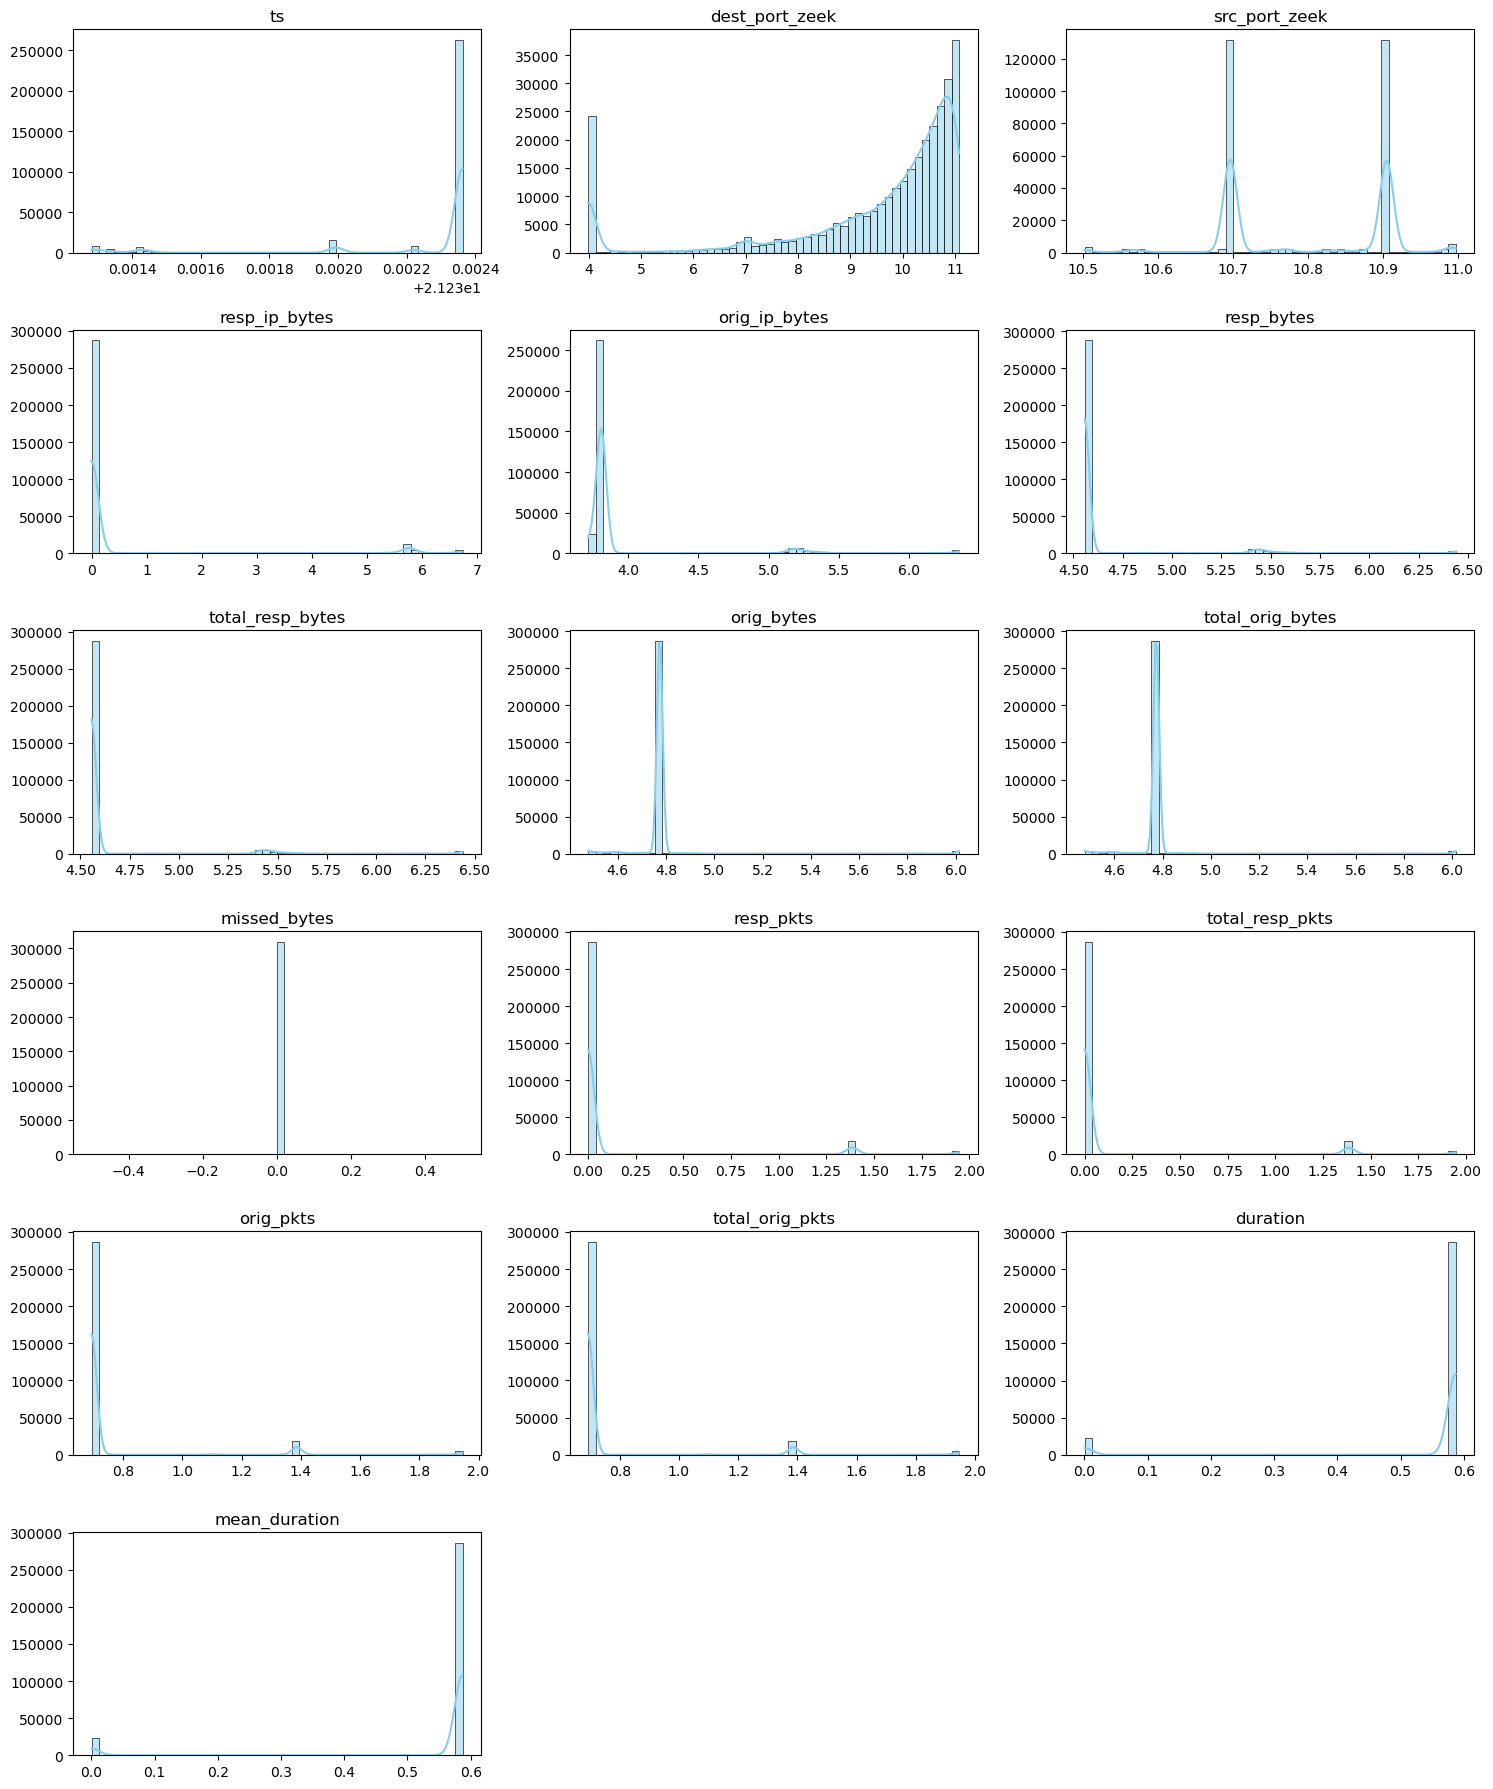

In [48]:
# ==========================================================
# BLOCCO 3b + 3c: Analisi feature numeriche, gestione outlier e trasformazione robusta
# ==========================================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

# ================================
# Step 0: Pulizia sicura della label_binary
# ================================
data['label_binary_clean'] = data['label_binary'].map({True:1, False:0, 'True':1, 'False':0, 1:1, 0:0})
data = data.dropna(subset=['label_binary_clean'])
data['label_binary'] = data['label_binary_clean'].astype(int)
data = data.drop(columns=['label_binary_clean'])

# ================================
# Step 1: Selezione feature numeriche
# ================================
num_features = data.select_dtypes(include=['int64','float64']).columns.tolist()
for col in ['label_binary','label_technique','label_tactic']:
    if col in num_features:
        num_features.remove(col)

# ================================
# Step 2: Varianza
# ================================
variance = data[num_features].var().sort_values(ascending=False)
selected_features = variance[variance > 0.01].index.tolist()
print(f"✅ Feature con varianza significativa: {selected_features}")

# ================================
# Step 3: Analisi outlier
# ================================
outlier_summary = {}
for col in selected_features:
    Q1, Q3 = data[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    outlier_summary[col] = ((data[col]<lower) | (data[col]>upper)).sum()
print("⚠️ Numero di outlier trovati per feature:")
display(pd.Series(outlier_summary))

# ================================
# Step 4: Trasformazione outlier (Winsorization + log)
# ================================
print("🏗️ Applicazione trasformazioni per gestire outlier...\n")
for col in selected_features:
    lower = data[col].quantile(0.01)
    upper = data[col].quantile(0.99)
    data[col] = np.clip(data[col], lower, upper)
    min_val = data[col].min()
    offset = abs(min_val)+1e-6 if min_val <= 0 else 0
    data[col] = np.log1p(data[col] + offset)
    data[col].replace([np.inf, -np.inf], np.nan, inplace=True)

# 🔧 Fix: rimozione eventuali NaN residui
data = data.dropna(subset=selected_features)

# ================================
# Step 5: Analisi post-transform
# ================================
print("\n📄 REPORT FINALE - Dataset post Winsorization + log\n")
print("🔹 Statistiche descrittive:")
display(data[selected_features].describe().T)

print("\n📝 Motivazione trasformazione:")
print(
    "- Alcune feature avevano outlier estremi che potevano distorcere le distribuzioni.\n"
    "- Winsorization: limita i valori ai percentili 1% e 99%, riducendo l'impatto degli outlier.\n"
    "- Log-transform: riduce l'asimmetria e migliora la stabilità numerica.\n"
    "- Il dataset risultante ha distribuzioni più compatte e valori pronti per scaling/normalizzazione."
)

# ================================
# Step 6: Visualizzazione distribuzioni post-transform
# ================================
cols = 3
rows = math.ceil(len(selected_features)/cols)
plt.figure(figsize=(max(10, cols*5), max(5, rows*3)))
for i, col in enumerate(selected_features, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(data[col].dropna(), bins=50, kde=True, color='skyblue')
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('')
plt.tight_layout()
plt.show()



🚀 [BLOCCO 4] FEATURE ENGINEERING AVANZATO

🔤 Inizio encoding feature categoriali...
📊 Trovate 10 feature categoriali: ['community_id', 'conn_state', 'history', 'src_ip_zeek', 'dest_ip_zeek', 'proto', 'service', 'uid', 'label_tactic', 'label_technique']
🔸 Applico CountEncoder...
🔸 Applico TargetEncoder...
✅ Encoding completato: 20 colonne create.

🧩 Combino feature numeriche e categoriali encodate...
📦 Feature matrix finale: 310034 righe, 36 colonne

📊 Calcolo Mutual Information (numeriche + categoriali encodate)...

📋 Top 20 feature per Mutual Information:


,Feature,MI_Score,MI_%,Cumulative_%
21,proto_count,0.092240,4.62,4.62
7,orig_bytes,0.088156,4.42,9.04
8,total_orig_bytes,0.087390,4.38,13.42
22,service_count,0.079110,3.96,17.38
27,conn_state_target,0.077905,3.90,21.28
23,uid_count,0.077617,3.89,25.17
34,label_tactic_target,0.077555,3.89,29.06
35,label_technique_target,0.077552,3.89,32.95
30,dest_ip_zeek_target,0.077494,3.88,36.83
26,community_id_target,0.077211,3.87,40.70


C:\Users\maria\AppData\Local\Temp\ipykernel_14136\1829574849.py:85: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  plt.tight_layout()
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


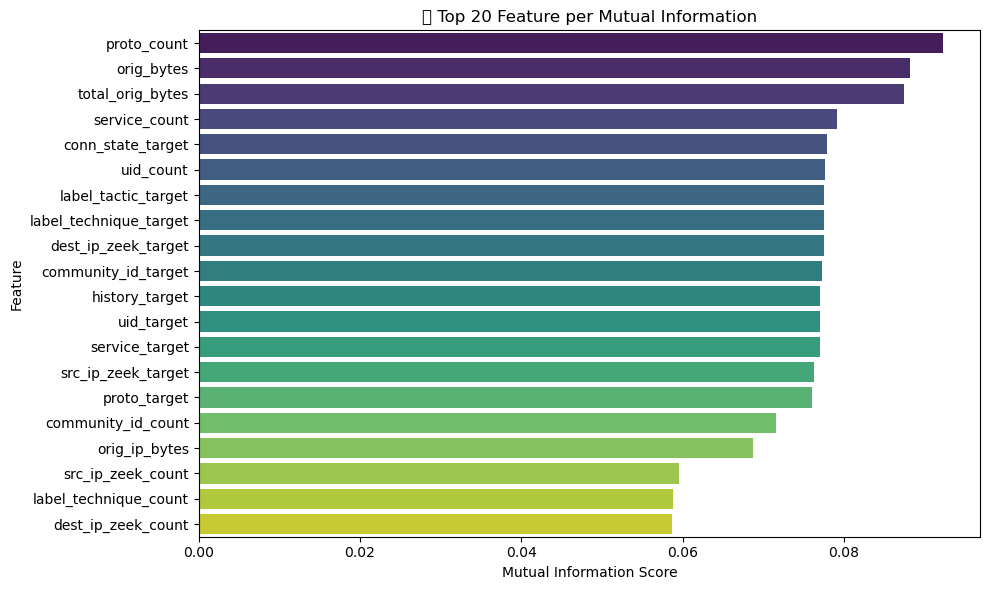

C:\Users\maria\AppData\Local\Temp\ipykernel_14136\1829574849.py:96: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


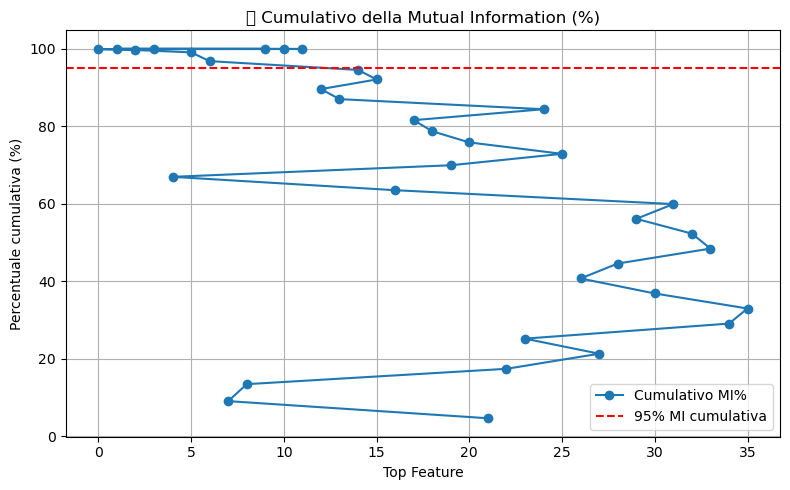


🎯 Selezione delle feature che spiegano il 95% della MI totale...
✅ Selezionate 27 feature su 36 totali.

🔍 Prime 10 feature selezionate:


,Feature,MI_Score,MI_%,Cumulative_%
21,proto_count,0.092240,4.62,4.62
7,orig_bytes,0.088156,4.42,9.04
8,total_orig_bytes,0.087390,4.38,13.42
22,service_count,0.079110,3.96,17.38
27,conn_state_target,0.077905,3.90,21.28
23,uid_count,0.077617,3.89,25.17
34,label_tactic_target,0.077555,3.89,29.06
35,label_technique_target,0.077552,3.89,32.95
30,dest_ip_zeek_target,0.077494,3.88,36.83
26,community_id_target,0.077211,3.87,40.70



🧮 PCA per riduzione dimensionalità...
📉 PCA: 5 componenti principali (95% varianza spiegata)


C:\Users\maria\AppData\Local\Temp\ipykernel_14136\1829574849.py:129: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


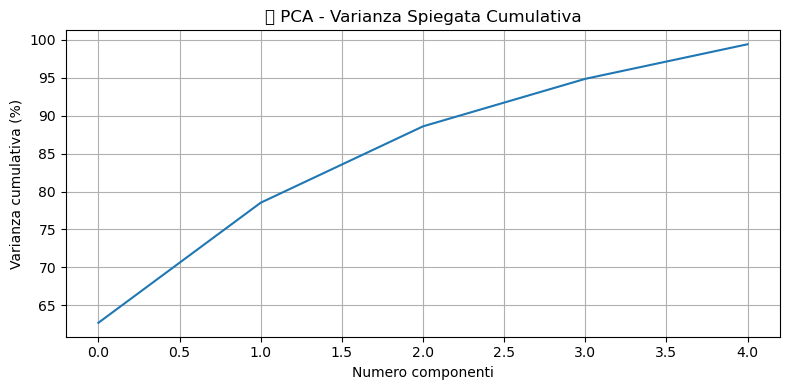


💾 Dataset salvati correttamente:
• X_selected_noPCA → (310034, 27)
• X_pca → (310034, 5)
• y_labels → (310034,)

✅ Fine BLOCCO 4 – Feature Engineering completato con successo.


In [49]:
# ==========================================================
# BLOCCO 4: Feature Engineering Avanzato (Numeriche + Categoriali)
# ==========================================================
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder, CountEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

print("\n🚀 [BLOCCO 4] FEATURE ENGINEERING AVANZATO")

# ================================
# Step 1️⃣ Encoding delle feature categoriali
# ================================
print("\n🔤 Inizio encoding feature categoriali...")

cat_features = data.select_dtypes(include=['object', 'category']).columns.tolist()
num_features = selected_features.copy()  # dal blocco 3C

if len(cat_features) == 0:
    print("⚠️ Nessuna feature categoriale trovata: salto encoding.")
    cat_encoded = pd.DataFrame()
else:
    print(f"📊 Trovate {len(cat_features)} feature categoriali: {cat_features}")

    # Count/Frequency Encoding
    print("🔸 Applico CountEncoder...")
    count_encoder = CountEncoder(cols=cat_features)
    data_encoded = count_encoder.fit_transform(data[cat_features])

    # Target Encoding
    print("🔸 Applico TargetEncoder...")
    target_encoder = TargetEncoder(cols=cat_features)
    data_target_encoded = target_encoder.fit_transform(data[cat_features], data['label_binary'])

    # Combina count + target
    cat_encoded = pd.concat([
        data_encoded.add_suffix('_count'),
        data_target_encoded.add_suffix('_target')
    ], axis=1)

    print(f"✅ Encoding completato: {cat_encoded.shape[1]} colonne create.")

# ================================
# Step 2️⃣ Combinazione numeriche + categoriali encodate
# ================================
print("\n🧩 Combino feature numeriche e categoriali encodate...")

X_full = pd.concat([
    data[num_features].reset_index(drop=True),
    cat_encoded.reset_index(drop=True)
], axis=1)
y = data['label_binary']

print(f"📦 Feature matrix finale: {X_full.shape[0]} righe, {X_full.shape[1]} colonne")

# ================================
# Step 3️⃣ Calcolo Mutual Information
# ================================
print("\n📊 Calcolo Mutual Information (numeriche + categoriali encodate)...")
mi_scores = mutual_info_classif(X_full.fillna(0), y, discrete_features=False, random_state=42)

mi_df = pd.DataFrame({
    'Feature': X_full.columns,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

mi_df['MI_%'] = (mi_df['MI_Score'] / mi_df['MI_Score'].sum() * 100).round(2)
mi_df['Cumulative_%'] = mi_df['MI_%'].cumsum().round(2)

print("\n📋 Top 20 feature per Mutual Information:")
display(mi_df.head(20))

# --- Visualizzazione grafica
plt.figure(figsize=(10,6))
sns.barplot(data=mi_df.head(20), y='Feature', x='MI_Score', palette='viridis')
plt.title("🔥 Top 20 Feature per Mutual Information")
plt.xlabel("Mutual Information Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(mi_df['Cumulative_%'].head(50), marker='o', label='Cumulativo MI%')
plt.axhline(95, color='red', linestyle='--', label='95% MI cumulativa')
plt.title("📈 Cumulativo della Mutual Information (%)")
plt.xlabel("Top Feature")
plt.ylabel("Percentuale cumulativa (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ================================
# Step 4️⃣ Selezione Feature
# ================================
print("\n🎯 Selezione delle feature che spiegano il 95% della MI totale...")
selected_mi_features = mi_df[mi_df['Cumulative_%'] <= 95]['Feature'].tolist()

X_selected = X_full[selected_mi_features]
print(f"✅ Selezionate {len(selected_mi_features)} feature su {X_full.shape[1]} totali.")

print("\n🔍 Prime 10 feature selezionate:")
display(mi_df.head(10))

# ================================
# Step 5️⃣ PCA (opzionale)
# ================================
print("\n🧮 PCA per riduzione dimensionalità...")
scaler_pca = StandardScaler()
X_scaled = scaler_pca.fit_transform(X_selected.fillna(0))

pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"📉 PCA: {X_pca.shape[1]} componenti principali (95% varianza spiegata)")

plt.figure(figsize=(8,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.xlabel("Numero componenti")
plt.ylabel("Varianza cumulativa (%)")
plt.title("📈 PCA - Varianza Spiegata Cumulativa")
plt.grid(True)
plt.tight_layout()
plt.show()

# ================================
# Step 6️⃣ Salvataggio dataset
# ================================
output_folder = r"C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22"
os.makedirs(output_folder, exist_ok=True)

X_selected.to_parquet(os.path.join(output_folder, "X_selected_noPCA.parquet"), index=False)
pd.DataFrame(X_pca).to_parquet(os.path.join(output_folder, "X_pca.parquet"), index=False)
y.to_csv(os.path.join(output_folder, "y_labels.csv"), index=False)

print("\n💾 Dataset salvati correttamente:")
print(f"• X_selected_noPCA → {X_selected.shape}")
print(f"• X_pca → {X_pca.shape}")
print(f"• y_labels → {y.shape}")
print("\n✅ Fine BLOCCO 4 – Feature Engineering completato con successo.")



📊 [BLOCCO 5a] Analisi bilanciamento delle classi...

Distribuzione label_binary:


,Count,Percent (%)
label_binary,,
1,310034,100.0



Distribuzione label_tactic:


,Count,Percent (%)
label_tactic,,
Resource Development,262409,84.64
Reconnaissance,28661,9.24
Discovery,16020,5.17
Defense Evasion,2894,0.93
Initial Access,16,0.01
Command and Control,14,0.00
Execution,8,0.00
Lateral Movement,6,0.00
Persistence,5,0.00


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


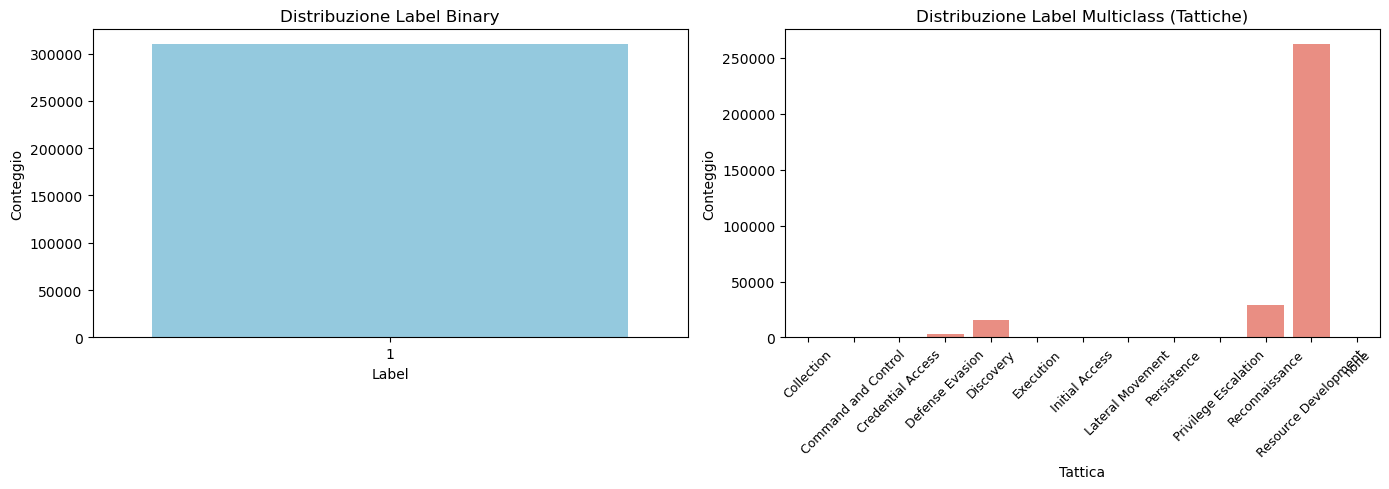

In [53]:
# ==========================================================
# BLOCCO 5a: Analisi bilanciamento delle classi
# ==========================================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("\n📊 [BLOCCO 5a] Analisi bilanciamento delle classi...")

# --- Binary
binary_counts = data['label_binary'].value_counts()
binary_perc = (binary_counts / binary_counts.sum() * 100).round(2)
binary_df = pd.DataFrame({'Count': binary_counts, 'Percent (%)': binary_perc})
print("\nDistribuzione label_binary:")
display(binary_df)

# --- Multiclass
multiclass_counts = data['label_tactic'].value_counts()
multiclass_perc = (multiclass_counts / multiclass_counts.sum() * 100).round(2)
multiclass_df = pd.DataFrame({'Count': multiclass_counts, 'Percent (%)': multiclass_perc})
print("\nDistribuzione label_tactic:")
display(multiclass_df)

# --- Grafici
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(x=binary_counts.index, y=binary_counts.values, ax=axes[0], color='skyblue')
axes[0].set_title("Distribuzione Label Binary")
axes[0].set_xlabel("Label")
axes[0].set_ylabel("Conteggio")

sns.barplot(x=multiclass_counts.index, y=multiclass_counts.values, ax=axes[1], color='salmon')
axes[1].set_title("Distribuzione Label Multiclass (Tattiche)")
axes[1].set_xlabel("Tattica")
axes[1].set_ylabel("Conteggio")
axes[1].tick_params(axis='x', rotation=45, labelsize=9)  # 👈 Ruota e riduci font

plt.tight_layout()
plt.show()




⚖️ [BLOCCO 5b] Creazione dataset bilanciato (3-class) ...
Righe totali con le 3 classi principali: 307090
Conteggio per classe prima del bilanciamento:
label_tactic_reduced
Resource Development    262409
Reconnaissance           28661
Discovery                16020
Name: count, dtype: int64
Classe più piccola ha 16020 campioni

📊 Distribuzione dopo bilanciamento:
label_tactic_reduced
Resource Development    16020
Reconnaissance          16020
Discovery               16020
Name: count, dtype: int64


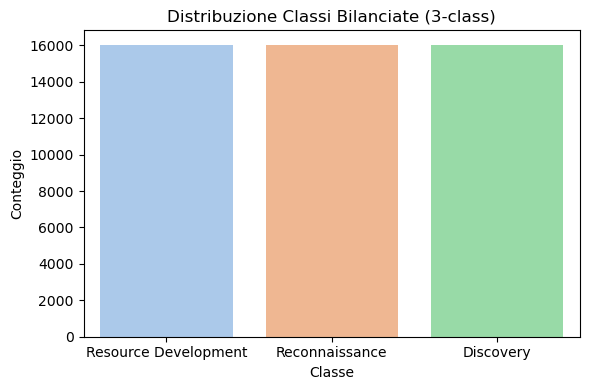

In [ ]:
# ==========================================================
# BLOCCO 5b: Creazione dataset bilanciato (3 classi principali)
# ==========================================================
from sklearn.utils import resample
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("\n⚖️ [BLOCCO 5b] Creazione dataset bilanciato (3-class) ...")

# 🔹 Definisci le 3 classi principali
top_classes = ['Resource Development', 'Reconnaissance', 'Discovery']

# 🔹 Pulisci eventuali spazi e converti a stringa
data['label_tactic'] = data['label_tactic'].astype(str).str.strip()

# 🔹 Filtra solo le righe appartenenti alle 3 classi principali
balanced_data = data[data['label_tactic'].isin(top_classes)].copy()
balanced_data['label_tactic_reduced'] = balanced_data['label_tactic']

print(f"Righe totali con le 3 classi principali: {len(balanced_data)}")

# 🔹 Trova la classe più piccola
class_counts = balanced_data['label_tactic_reduced'].value_counts()
min_count = class_counts.min()
print("Conteggio per classe prima del bilanciamento:")
print(class_counts)
print(f"Classe più piccola ha {min_count} campioni")

# 🔹 Downsampling per bilanciare tutte le classi
balanced_samples = []
for cls in top_classes:
    cls_df = balanced_data[balanced_data['label_tactic_reduced'] == cls]
    cls_down = resample(cls_df, replace=False, n_samples=min_count, random_state=42)
    balanced_samples.append(cls_down)

balanced_data = pd.concat(balanced_samples).sample(frac=1, random_state=42).reset_index(drop=True)

# 🔹 Verifica distribuzione
print("\n📊 Distribuzione dopo bilanciamento:")
print(balanced_data['label_tactic_reduced'].value_counts())

# --- Grafico
plt.figure(figsize=(6,4))
sns.barplot(
    x=balanced_data['label_tactic_reduced'].value_counts().index,
    y=balanced_data['label_tactic_reduced'].value_counts().values,
    palette='pastel'
)
plt.title("Distribuzione Classi Bilanciate (3-class)")
plt.xlabel("Classe")
plt.ylabel("Conteggio")
plt.tight_layout()
plt.show()

# 🔹 Salvataggio dataset bilanciato
output_folder = r"C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22"
os.makedirs(output_folder, exist_ok=True)
balanced_data.to_parquet(os.path.join(output_folder, "balanced_data_3class.parquet"), index=False)
print("💾 Dataset bilanciato salvato come 'balanced_data_3class.parquet'")




⚙️ [BLOCCO 5c] Consolidamento classi rare e calcolo class weights ibridi...

📊 Distribuzione classi multiclass ridotte:


,Count,Percent (%)
label_tactic_reduced,,
Resource Development,262409,84.64
Reconnaissance,28661,9.24
Discovery,16020,5.17
Other,2944,0.95


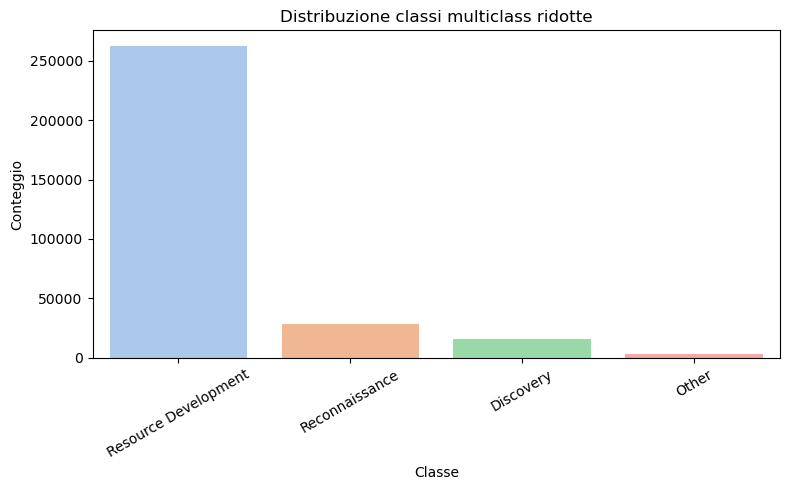


⚖️ Class Weights (ibridi frequenza + difficoltà):
   Resource Development: 0.000
   Reconnaissance: 0.052
   Discovery: 0.110
   Other: 3.838

✅ Class weights ibridi salvati in 'model_data/class_weights_dict.pkl'

📝 Motivazione:
- I pesi delle classi non si basano solo sulla frequenza.
- Considerano anche la quantità media di informazione che le feature forniscono rispetto alla classe (Mutual Information).
- Classi meno frequenti e più difficili da distinguere ricevono un peso maggiore.
- Questo approccio migliora la capacità del modello di apprendere pattern rari ma informativamente rilevanti.


In [ ]:
# ==========================================================
# BLOCCO 5c: Consolidamento classi multiclass rare + class weights “intelligenti”
# ==========================================================
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import mutual_info_classif
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import os

print("\n⚙️ [BLOCCO 5c] Consolidamento classi rare e calcolo class weights ibridi...")

# ================================
# Step 1️⃣ Definizione classi principali
# ================================
main_classes = ['Resource Development', 'Reconnaissance', 'Discovery']

data['label_tactic_reduced'] = data['label_tactic'].apply(
    lambda x: x if x in main_classes else 'Other'
)

# ================================
# Step 2️⃣ Distribuzione classi ridotte
# ================================
reduced_counts = data['label_tactic_reduced'].value_counts()
reduced_perc = (reduced_counts / reduced_counts.sum() * 100).round(2)
reduced_df = pd.DataFrame({'Count': reduced_counts, 'Percent (%)': reduced_perc})

print("\n📊 Distribuzione classi multiclass ridotte:")
display(reduced_df)

# --- Grafico distribuzione
plt.figure(figsize=(8,5))
sns.barplot(x=reduced_counts.index, y=reduced_counts.values, palette='pastel')
plt.title("Distribuzione classi multiclass ridotte")
plt.xlabel("Classe")
plt.ylabel("Conteggio")
plt.xticks(rotation=30)  # Ruota label per leggibilità
plt.tight_layout()
plt.show()

# ================================
# Step 3️⃣ Calcolo class weights standard
# ================================
classes = reduced_counts.index.to_numpy()
base_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=data['label_tactic_reduced']
)
base_weights_dict = dict(zip(classes, base_weights))

# ================================
# Step 4️⃣ Calcolo difficoltà media per classe (Weighted Mutual Information)
# ================================
# Classi con feature meno informative → peso maggiore
class_difficulty = {}
for cls in classes:
    subset = data[data['label_tactic_reduced'] == cls]
    if len(subset) > 10:
        mi_local = mutual_info_classif(X_full.loc[subset.index].fillna(0), subset['label_binary'])
        class_difficulty[cls] = 1 / (np.mean(mi_local) + 1e-6)
    else:
        class_difficulty[cls] = 1.0  # fallback per classi troppo piccole

# Normalizzazione difficoltà
diff_values = np.array(list(class_difficulty.values()))
diff_values /= diff_values.mean()

# ================================
# Step 5️⃣ Combina frequenza + difficoltà
# ================================
hybrid_weights = {}
for cls, base_w in base_weights_dict.items():
    hybrid_weights[cls] = base_w * class_difficulty[cls]

# Normalizza su media = 1
mean_w = np.mean(list(hybrid_weights.values()))
hybrid_weights = {k: v / mean_w for k, v in hybrid_weights.items()}

# ================================
# Step 6️⃣ Stampa e salvataggio
# ================================
print("\n⚖️ Class Weights (ibridi frequenza + difficoltà):")
for k, v in hybrid_weights.items():
    print(f"   {k}: {v:.3f}")

os.makedirs("model_data", exist_ok=True)
joblib.dump(hybrid_weights, "model_data/class_weights_dict.pkl")

print("\n✅ Class weights ibridi salvati in 'model_data/class_weights_dict.pkl'")

# ================================
# 🔍 Giustificazione
# ================================
print("\n📝 Motivazione:")
print(
    "- I pesi delle classi non si basano solo sulla frequenza.\n"
    "- Considerano anche la quantità media di informazione che le feature forniscono rispetto alla classe (Mutual Information).\n"
    "- Classi meno frequenti e più difficili da distinguere ricevono un peso maggiore.\n"
    "- Questo approccio migliora la capacità del modello di apprendere pattern rari ma informativamente rilevanti."
)


In [ ]:
# ==========================================================
# BLOCCO 6a BALANCED: Preparazione dataset per Autoencoder e classificazione
# ==========================================================
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

print("🏗️ Inizio preparazione dataset per autoencoder e classificazione (su dataset bilanciato)...\n")

# ================================
# 1️⃣ Definizione target e dataset di lavoro
# ================================
target_multiclass = 'label_tactic_reduced'

# Controllo che le colonne esistano
required_cols = ['label_binary', 'label_technique', 'label_tactic', target_multiclass]
missing_cols = [c for c in required_cols if c not in balanced_data.columns]
if missing_cols:
    raise KeyError(f"❌ Colonne mancanti nel dataset bilanciato: {missing_cols}")

# Label (multiclasse e binaria)
y_multiclass = balanced_data[target_multiclass].copy()
y_binary = balanced_data['label_binary'].copy()

# ================================
# 2️⃣ Feature set
# ================================
feature_data = balanced_data.drop(columns=['label_binary', 'label_technique', 'label_tactic'])

# ================================
# 3️⃣ Conversione datetime → numerico
# ================================
datetime_cols = feature_data.select_dtypes(include=['datetime64']).columns.tolist()
for col in datetime_cols:
    feature_data[col] = feature_data[col].astype('int64') / 1e9  # secondi Unix

# ================================
# 4️⃣ Selezione automatica feature numeriche ad alta varianza
# ================================
# selected_features: lista di feature numeriche con varianza > 0.01 calcolata precedentemente
numerical_high_var = [col for col in selected_features if col in feature_data.columns]

# ================================
# 5️⃣ Frequency Encoding su feature categoriali
# ================================
cat_features = feature_data.select_dtypes(include=['object','category']).columns.tolist()
encoded_data = feature_data.copy()

for col in cat_features:
    freq = encoded_data[col].value_counts(normalize=True)
    encoded_data[col] = encoded_data[col].map(freq)

# ================================
# 6️⃣ Unione feature numeriche ad alta varianza + categoriali trasformate
# ================================
encoded_data = encoded_data[numerical_high_var + cat_features]

# ================================
# 7️⃣ Scaling MinMax per Autoencoder
# ================================
scaler_auto = MinMaxScaler()
X_autoencoder = pd.DataFrame(
    scaler_auto.fit_transform(encoded_data),
    columns=encoded_data.columns
)

# ================================
# 8️⃣ Output finale e riepilogo
# ================================
print(f"✅ Dataset pronto per l'autoencoder: {X_autoencoder.shape}")
print(f"🔹 Numero di feature totali: {X_autoencoder.shape[1]}")
print(f"🔹 Classi multiclasse bilanciate: {y_multiclass.unique().tolist()}")
print(f"🔹 Classi binarie: {y_binary.unique().tolist()}")

print("\n📊 Distribuzione finale delle classi (bilanciato):")
display(y_multiclass.value_counts())

print("✅ Fine preparazione: X_autoencoder, y_multiclass, y_binary pronti per i modelli.")

# ================================
# 🔹 Spiegazione:
# - Solo le feature numeriche con varianza >0.01 sono considerate, perché quelle con varianza molto bassa portano poco segnale.
# - La selezione è automatica: la soglia si adatta ai dati, nessuna scelta manuale richiesta.
# - Tutte le feature categoriali vengono trasformate in valori numerici tramite frequency encoding.
# - L'encoder riceve quindi tutte le feature informative numeriche + tutte le categoriali trasformate.
# - Infine, lo scaling MinMax normalizza i valori tra 0 e 1, pronto per l'autoencoder.


🏗️ Inizio preparazione dataset per autoencoder e classificazione (su dataset bilanciato)...

✅ Dataset pronto per l'autoencoder: (48060, 25)
🔹 Numero di feature totali: 25
🔹 Classi multiclasse bilanciate: ['Resource Development', 'Reconnaissance', 'Discovery']
🔹 Classi binarie: [1]

📊 Distribuzione finale delle classi (bilanciato):


label_tactic_reduced
Resource Development    16020
Reconnaissance          16020
Discovery               16020
Name: count, dtype: int64

✅ Fine preparazione: X_autoencoder, y_multiclass, y_binary pronti per i modelli.


In [ ]:
# ==========================================================
# BLOCCO 6b Imbalanced: Preparazione dataset (classi sbilanciate con class weights)
# ==========================================================
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib
import os

print("🏗️ Inizio preparazione dataset per autoencoder e classificazione (dataset sbilanciato con class weights)...\n")

# ================================
# 1️⃣ Definizione target e dataset
# ================================
target_multiclass_imb = 'label_tactic_reduced'
required_cols = ['label_binary', 'label_technique', 'label_tactic', target_multiclass_imb]
missing_cols = [c for c in required_cols if c not in data.columns]
if missing_cols:
    raise KeyError(f"❌ Colonne mancanti nel dataset originale: {missing_cols}")

# Target (multiclass ridotto + binario)
y_multiclass_imb = data[target_multiclass_imb].copy()
y_binary_imb = data['label_binary'].copy()

# ================================
# 2️⃣ Feature set (senza label)
# ================================
feature_data_imb = data.drop(columns=['label_binary', 'label_technique', 'label_tactic', target_multiclass_imb])

# ================================
# 3️⃣ Conversione datetime → numerico (timestamp)
# ================================
datetime_cols = feature_data_imb.select_dtypes(include=['datetime64']).columns.tolist()
for col in datetime_cols:
    feature_data_imb[col] = feature_data_imb[col].astype('int64') / 1e9

# ================================
# 4️⃣ Selezione automatica feature numeriche ad alta varianza
# ================================
numerical_high_var_imb = [col for col in selected_features if col in feature_data_imb.columns]

# ================================
# 5️⃣ Frequency Encoding per feature categoriali
# ================================
cat_features_imb = feature_data_imb.select_dtypes(include=['object','category']).columns.tolist()
encoded_data_imb = feature_data_imb.copy()

for col in cat_features_imb:
    freq = encoded_data_imb[col].value_counts(normalize=True)
    encoded_data_imb[col] = encoded_data_imb[col].map(freq)

# Mappatura finale feature (utile per pipeline o export)
feature_mapping_imb = {col: col for col in numerical_high_var_imb + cat_features_imb}

# ================================
# 6️⃣ Scaling MinMax
# ================================
encoded_data_imb = encoded_data_imb[numerical_high_var_imb + cat_features_imb]

scaler_auto_imb = MinMaxScaler()
X_autoencoder_imb = pd.DataFrame(
    scaler_auto_imb.fit_transform(encoded_data_imb),
    columns=encoded_data_imb.columns
)

# ================================
# 7️⃣ Salvataggio modelli e pesi
# ================================
os.makedirs("model_data", exist_ok=True)
joblib.dump(scaler_auto_imb, "model_data/scaler_auto_imbalanced.pkl")
joblib.dump(feature_mapping_imb, "model_data/feature_mapping_imbalanced.pkl")

print(f"✅ Dataset sbilanciato pronto: {X_autoencoder_imb.shape}")
print(f"🔹 Numero di feature totali: {X_autoencoder_imb.shape[1]}")
print(f"🔹 Classi multiclass (sbilanciate): {y_multiclass_imb.unique().tolist()}")

# Carica class weights salvati nel blocco precedente
class_weights_dict = joblib.load("model_data/class_weights_dict.pkl")
print(f"🔹 Class weights caricati da 'class_weights_dict.pkl'")

print("\n📊 Distribuzione classi (originale, sbilanciata):")
display(y_multiclass_imb.value_counts())

print("✅ Fine preparazione: X_autoencoder_imb, y_multiclass_imb, y_binary_imb pronti per modelli con class weights.")


🏗️ Inizio preparazione dataset per autoencoder e classificazione (dataset sbilanciato con class weights)...

✅ Dataset sbilanciato pronto: (310034, 24)
🔹 Numero di feature totali: 24
🔹 Classi multiclass (sbilanciate): ['Other', 'Reconnaissance', 'Resource Development', 'Discovery']
🔹 Class weights caricati da 'class_weights_dict.pkl'

📊 Distribuzione classi (originale, sbilanciata):


label_tactic_reduced
Resource Development    262409
Reconnaissance           28661
Discovery                16020
Other                     2944
Name: count, dtype: int64

✅ Fine preparazione: X_autoencoder_imb, y_multiclass_imb, y_binary_imb pronti per modelli con class weights.


🏗️ Inizio costruzione e training dell'Autoencoder - Bilanciato...
Epoch 1/40 [------------------------------] loss: 0.017745 | val_loss: 0.001757 | tempo: 9.77s
Epoch 2/40 [━-----------------------------] loss: 0.001473 | val_loss: 0.001008 | tempo: 4.21s
Epoch 3/40 [━━----------------------------] loss: 0.001084 | val_loss: 0.000853 | tempo: 3.87s
Epoch 4/40 [━━━---------------------------] loss: 0.000871 | val_loss: 0.000705 | tempo: 4.05s
Epoch 5/40 [━━━---------------------------] loss: 0.000770 | val_loss: 0.000651 | tempo: 4.18s
Epoch 6/40 [━━━━--------------------------] loss: 0.000729 | val_loss: 0.000626 | tempo: 4.30s
Epoch 7/40 [━━━━━-------------------------] loss: 0.000665 | val_loss: 0.000553 | tempo: 4.16s
Epoch 8/40 [━━━━━━------------------------] loss: 0.000593 | val_loss: 0.000546 | tempo: 3.65s
Epoch 9/40 [━━━━━━------------------------] loss: 0.000563 | val_loss: 0.000539 | tempo: 5.54s
Epoch 10/40 [━━━━━━━-----------------------] loss: 0.000547 | val_loss: 0.00049

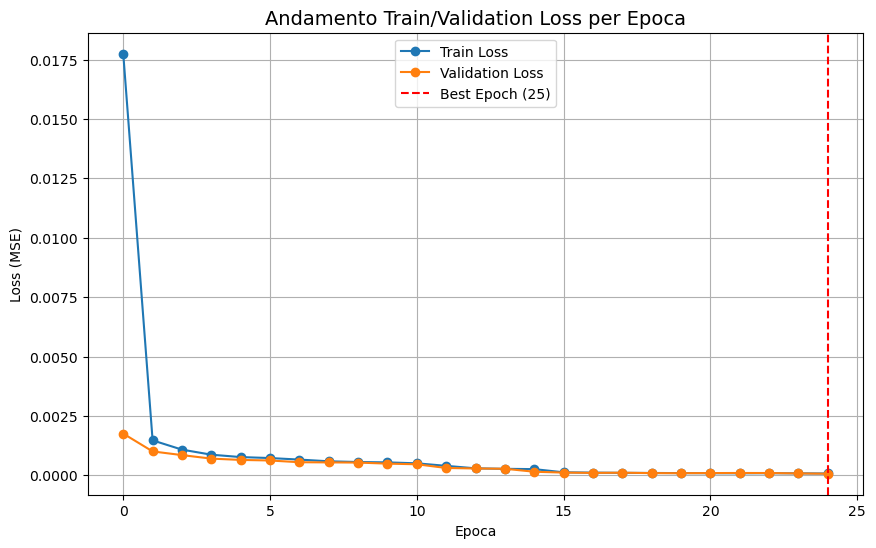

In [ ]:
# ==========================================================
# BLOCCO 7a BALANCED: Addestramento Autoencoder con logging avanzato,
# EarlyStopping, salvataggio best epoch e grafico
# ==========================================================
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Riduce warning TF/CUDA

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping
import pandas as pd
import matplotlib.pyplot as plt
import time
import joblib

# Pulizia memoria Keras
tf.keras.backend.clear_session()

print("🏗️ Inizio costruzione e training dell'Autoencoder - Bilanciato...")

# ==============================
# 1️⃣ Parametri
# ==============================
input_dim = X_autoencoder.shape[1]
latent_dim = 16

# ==============================
# 2️⃣ Costruzione Autoencoder
# ==============================
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(latent_dim, activation='relu', name='latent_vector')(encoded)
decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# ==============================
# 3️⃣ EarlyStopping avanzato
# ==============================
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=1e-4,
    restore_best_weights=True,
    verbose=1
)

# ==============================
# 4️⃣ Callback custom per logging avanzato
# ==============================
class ProgressLogger(Callback):
    def on_train_begin(self, logs=None):
        self.epoch_logs = []

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        elapsed = time.time() - self.start_time
        self.epoch_logs.append({
            'epoch': epoch+1,
            'loss': logs['loss'],
            'val_loss': logs['val_loss'],
            'time_s': elapsed
        })
        bar_len = 30
        progress = int(bar_len * (epoch+1)/self.params['epochs'])
        bar = '━' * progress + '-' * (bar_len - progress)
        print(f"\rEpoch {epoch+1}/{self.params['epochs']} [{bar}] "
              f"loss: {logs['loss']:.6f} | val_loss: {logs['val_loss']:.6f} | tempo: {elapsed:.2f}s", end='\n')

# ==============================
# 5️⃣ Training
# ==============================
logger = ProgressLogger()
history = autoencoder.fit(
    X_autoencoder,
    X_autoencoder,
    epochs=40,
    batch_size=64,
    validation_split=0.1,
    shuffle=True,
    verbose=0,
    callbacks=[early_stop, logger]
)

print("\n✅ Autoencoder bilanciato addestrato con successo.")

# ==============================
# 6️⃣ Recupero best epoch
# ==============================
best_epoch_idx = history.history['val_loss'].index(min(history.history['val_loss']))
best_train_loss = history.history['loss'][best_epoch_idx]
best_val_loss = history.history['val_loss'][best_epoch_idx]
best_time = logger.epoch_logs[best_epoch_idx]['time_s']

print(f"🏆 Best epoch: {best_epoch_idx+1}")
print(f"    Train loss: {best_train_loss:.6f}")
print(f"    Validation loss: {best_val_loss:.6f}")
print(f"    Tempo per epoca: {best_time:.2f}s")

# ==============================
# 7️⃣ Estrazione encoder e embeddings
# ==============================
encoder = Model(inputs=input_layer, outputs=autoencoder.get_layer('latent_vector').output)
X_latent = encoder.predict(X_autoencoder)
X_classifier = pd.DataFrame(X_latent, columns=[f'latent_{i}' for i in range(latent_dim)])
y_classifier = y_multiclass.reset_index(drop=True)

# Controllo NaN
assert not y_classifier.isna().any(), "Errore: y_classifier contiene NaN"

print(f"✅ Embeddings generati: {X_classifier.shape}")

# ==============================
# 8️⃣ Salvataggio embeddings
# ==============================
os.makedirs("model_data", exist_ok=True)
X_classifier.to_csv("model_data/X_classifier_balanced.csv", index=False)
y_classifier.to_csv("model_data/y_classifier_balanced.csv", index=False)
encoder.save("model_data/encoder_balanced.keras")
print("✅ Embeddings e encoder salvati correttamente")

# ==============================
# 9️⃣ Grafico Train vs Validation Loss
# ==============================
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.axvline(x=best_epoch_idx, color='r', linestyle='--', label=f'Best Epoch ({best_epoch_idx+1})')
plt.title("Andamento Train/Validation Loss - Bilanciato", fontsize=14)
plt.xlabel("Epoca")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# ==========================================================
# BLOCCO 7b IMBALANCED: Addestramento Autoencoder con logging avanzato
# ==========================================================
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping
import pandas as pd
import matplotlib.pyplot as plt
import time
import joblib

# Pulizia memoria Keras
tf.keras.backend.clear_session()

print("🏗️ Inizio costruzione e training dell'Autoencoder - Sbilanciato...")

# ==============================
# 1️⃣ Parametri
# ==============================
input_dim_imb = X_autoencoder_imb.shape[1]
latent_dim_imb = 16

# ==============================
# 2️⃣ Costruzione Autoencoder
# ==============================
input_layer_imb = Input(shape=(input_dim_imb,))
encoded_imb = Dense(64, activation='relu')(input_layer_imb)
encoded_imb = Dense(32, activation='relu')(encoded_imb)
encoded_imb = Dense(latent_dim_imb, activation='relu', name='latent_vector_imb')(encoded_imb)
decoded_imb = Dense(32, activation='relu')(encoded_imb)
decoded_imb = Dense(64, activation='relu')(decoded_imb)
decoded_imb = Dense(input_dim_imb, activation='sigmoid')(decoded_imb)

autoencoder_imb = Model(inputs=input_layer_imb, outputs=decoded_imb)
autoencoder_imb.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# ==============================
# 3️⃣ EarlyStopping avanzato
# ==============================
early_stop_imb = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=1e-4,
    restore_best_weights=True,
    verbose=1
)

# ==============================
# 4️⃣ Callback custom con logging avanzato
# ==============================
class ProgressLoggerImb(Callback):
    def on_train_begin(self, logs=None):
        self.epoch_logs = []

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        elapsed = time.time() - self.start_time
        self.epoch_logs.append({
            'epoch': epoch+1,
            'loss': logs['loss'],
            'val_loss': logs['val_loss'],
            'time_s': elapsed
        })
        bar_len = 30
        progress = int(bar_len * (epoch+1)/self.params['epochs'])
        bar = '━' * progress + '-' * (bar_len - progress)
        print(f"\rEpoch {epoch+1}/{self.params['epochs']} [{bar}] "
              f"loss: {logs['loss']:.6f} | val_loss: {logs['val_loss']:.6f} | tempo: {elapsed:.2f}s", end='\n')

# ==============================
# 5️⃣ Training
# ==============================
logger_imb = ProgressLoggerImb()
history_imb = autoencoder_imb.fit(
    X_autoencoder_imb,
    X_autoencoder_imb,
    epochs=40,
    batch_size=64,
    validation_split=0.1,
    shuffle=True,
    verbose=0,
    callbacks=[early_stop_imb, logger_imb]
)

print("\n✅ Autoencoder sbilanciato addestrato con successo.")

# ==============================
# 6️⃣ Recupero best epoch
# ==============================
best_epoch_idx_imb = history_imb.history['val_loss'].index(min(history_imb.history['val_loss']))
best_train_loss_imb = history_imb.history['loss'][best_epoch_idx_imb]
best_val_loss_imb = history_imb.history['val_loss'][best_epoch_idx_imb]
best_time_imb = logger_imb.epoch_logs[best_epoch_idx_imb]['time_s']

print(f"🏆 Best epoch: {best_epoch_idx_imb+1}")
print(f"    Train loss: {best_train_loss_imb:.6f}")
print(f"    Validation loss: {best_val_loss_imb:.6f}")
print(f"    Tempo per epoca: {best_time_imb:.2f}s")

# ==============================
# 7️⃣ Estrazione encoder e embeddings
# ==============================
encoder_imb = Model(inputs=input_layer_imb, outputs=autoencoder_imb.get_layer('latent_vector_imb').output)
X_latent_imb = encoder_imb.predict(X_autoencoder_imb)
X_classifier_imb = pd.DataFrame(X_latent_imb, columns=[f'latent_imb_{i}' for i in range(latent_dim_imb)])
y_classifier_imb = y_multiclass_imb.reset_index(drop=True)

# Controllo NaN
assert not y_classifier_imb.isna().any(), "Errore: y_classifier_imb contiene NaN"

print(f"✅ Embeddings generati: {X_classifier_imb.shape}")

# ==============================
# 8️⃣ Salvataggio embeddings e encoder
# ==============================
os.makedirs("model_data", exist_ok=True)
X_classifier_imb.to_csv("model_data/X_classifier_imbalanced.csv", index=False)
y_classifier_imb.to_csv("model_data/y_classifier_imbalanced.csv", index=False)
joblib.dump(encoder_imb, "model_data/encoder_imbalanced.pkl")
joblib.dump(class_weights_dict, "model_data/class_weights_dict.pkl")

# ==============================
# 9️⃣ Grafico Train vs Validation Loss
# ==============================
plt.figure(figsize=(10,6))
plt.plot(history_imb.history['loss'], label='Train Loss', marker='o')
plt.plot(history_imb.history['val_loss'], label='Validation Loss', marker='o')
plt.axvline(x=best_epoch_idx_imb, color='r', linestyle='--', label=f'Best Epoch ({best_epoch_idx_imb+1})')
plt.title("Autoencoder IMBALANCED - Andamento Train/Validation Loss", fontsize=14)
plt.xlabel("Epoca")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()


🏗️ Inizio costruzione e training dell'Autoencoder - Sbilanciato..
Epoch 1/40 [------------------------------] loss: 0.001995 | val_loss: 0.118008 | tempo: 32.53s
Epoch 2/40 [━-----------------------------] loss: 0.000155 | val_loss: 0.119625 | tempo: 26.22s
Epoch 3/40 [━━----------------------------] loss: 0.000063 | val_loss: 0.118025 | tempo: 27.10s
Epoch 4/40 [━━━---------------------------] loss: 0.000047 | val_loss: 0.118666 | tempo: 26.80s
Epoch 5/40 [━━━---------------------------] loss: 0.000041 | val_loss: 0.114495 | tempo: 20.68s
Epoch 6/40 [━━━━--------------------------] loss: 0.000031 | val_loss: 0.116025 | tempo: 24.13s
Epoch 7/40 [━━━━━-------------------------] loss: 0.000025 | val_loss: 0.118520 | tempo: 23.86s
Epoch 8/40 [━━━━━━------------------------] loss: 0.000024 | val_loss: 0.117911 | tempo: 40.88s
Epoch 9/40 [━━━━━━------------------------] loss: 0.000024 | val_loss: 0.119039 | tempo: 24.09s
Epoch 10/40 [━━━━━━━-----------------------] loss: 0.000019 | val_loss

KeyboardInterrupt: 

🏗️ Suddivisione dataset in train/test e analisi bilanciamento classi...
✅ Split completato.
Train: (38448, 16), Test: (9612, 16)

📊 Distribuzione classi nel TRAIN:
label_tactic_reduced
Resource Development    33.33
Reconnaissance          33.33
Discovery               33.33
Name: proportion, dtype: float64

📊 Distribuzione classi nel TEST:
label_tactic_reduced
Discovery               33.33
Reconnaissance          33.33
Resource Development    33.33
Name: proportion, dtype: float64


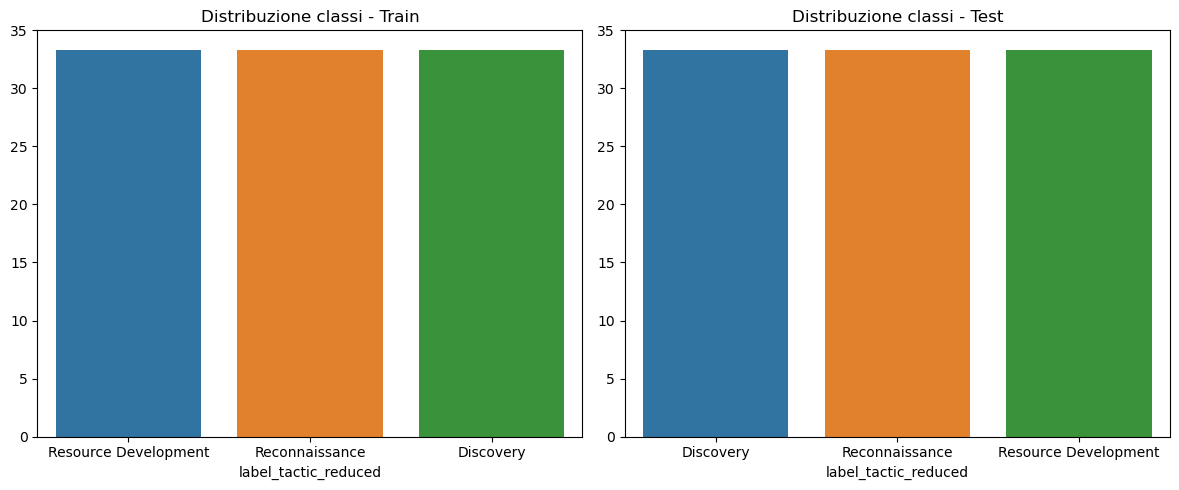


⚙️ Applicazione StandardScaler sugli embeddings latenti...
✅ Scaling completato.


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

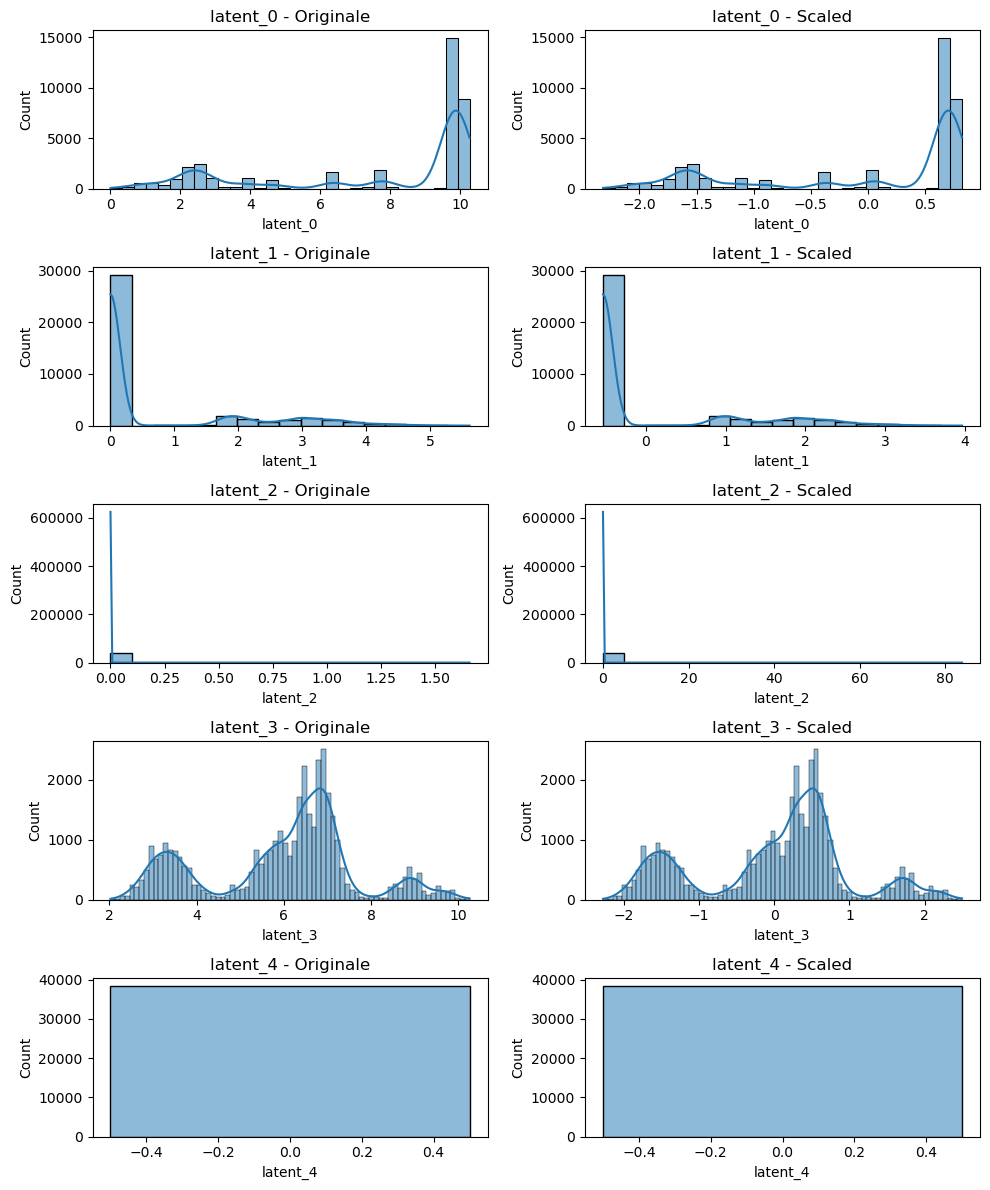


✅ Dataset finale pronto per classificazione multiclasse.
Train: (38448, 16), Test: (9612, 16)


In [ ]:
# ==========================================================
# BLOCCO 8a: Train/Test Split + StandardScaler + Analisi distribuzioni
# ==========================================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

print("🏗️ Suddivisione dataset in train/test e analisi bilanciamento classi...")

# 1️⃣ Split stratificato
X_train, X_test, y_train, y_test = train_test_split(
    X_classifier,
    y_classifier,
    test_size=0.2,
    stratify=y_classifier,
    random_state=42
)

print("✅ Split completato.")
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

# 2️⃣ Percentuali per categoria
train_dist = y_train.value_counts(normalize=True) * 100
test_dist = y_test.value_counts(normalize=True) * 100

print("\n📊 Distribuzione classi nel TRAIN:")
print(train_dist.round(2))
print("\n📊 Distribuzione classi nel TEST:")
print(test_dist.round(2))

# 3️⃣ Grafico distribuzione classi
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(x=train_dist.index, y=train_dist.values, ax=axes[0])
axes[0].set_title("Distribuzione classi - Train")
sns.barplot(x=test_dist.index, y=test_dist.values, ax=axes[1])
axes[1].set_title("Distribuzione classi - Test")
plt.tight_layout()
plt.show()

# 4️⃣ Scaling (solo train, poi test)
print("\n⚙️ Applicazione StandardScaler sugli embeddings latenti...")
scaler_latent = StandardScaler()
X_train_scaled = pd.DataFrame(scaler_latent.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler_latent.transform(X_test), columns=X_test.columns)
print("✅ Scaling completato.")

# 5️⃣ Visualizzazione confronto pre/post scaling su alcune feature
sample_features = X_train.columns[:5]
fig, axes = plt.subplots(len(sample_features), 2, figsize=(10, 12))
for i, feat in enumerate(sample_features):
    sns.histplot(X_train[feat], ax=axes[i, 0], kde=True)
    axes[i, 0].set_title(f"{feat} - Originale")
    sns.histplot(X_train_scaled[feat], ax=axes[i, 1], kde=True)
    axes[i, 1].set_title(f"{feat} - Scaled")
plt.tight_layout()
plt.show()

print(f"\n✅ Dataset finale pronto per classificazione multiclasse.")
print(f"Train: {X_train_scaled.shape}, Test: {X_test_scaled.shape}")


🏗️ Suddivisione IMBALANCED dataset in train/test e analisi bilanciamento classi...
✅ Split completato (Imbalanced).
Train: (248027, 16), Test: (62007, 16)

📊 Distribuzione classi nel TRAIN (Imbalanced):
label_tactic_reduced
Resource Development    84.64
Reconnaissance           9.24
Discovery                5.17
Other                    0.95
Name: proportion, dtype: float64

📊 Distribuzione classi nel TEST (Imbalanced):
label_tactic_reduced
Resource Development    84.64
Reconnaissance           9.24
Discovery                5.17
Other                    0.95
Name: proportion, dtype: float64


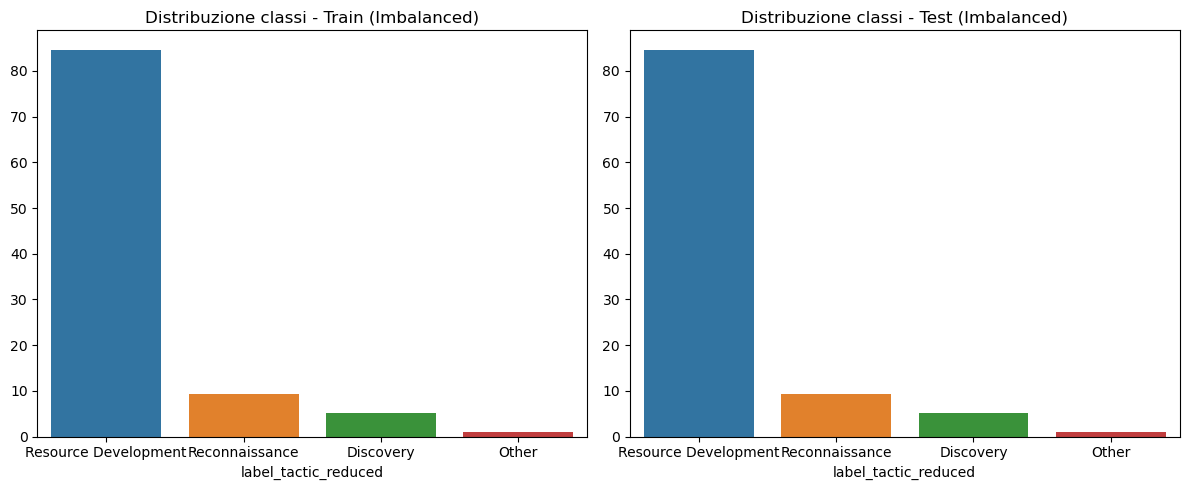


⚙️ Applicazione StandardScaler sugli embeddings latenti (Imbalanced)...
✅ Scaling completato (Imbalanced).


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


KeyboardInterrupt: 

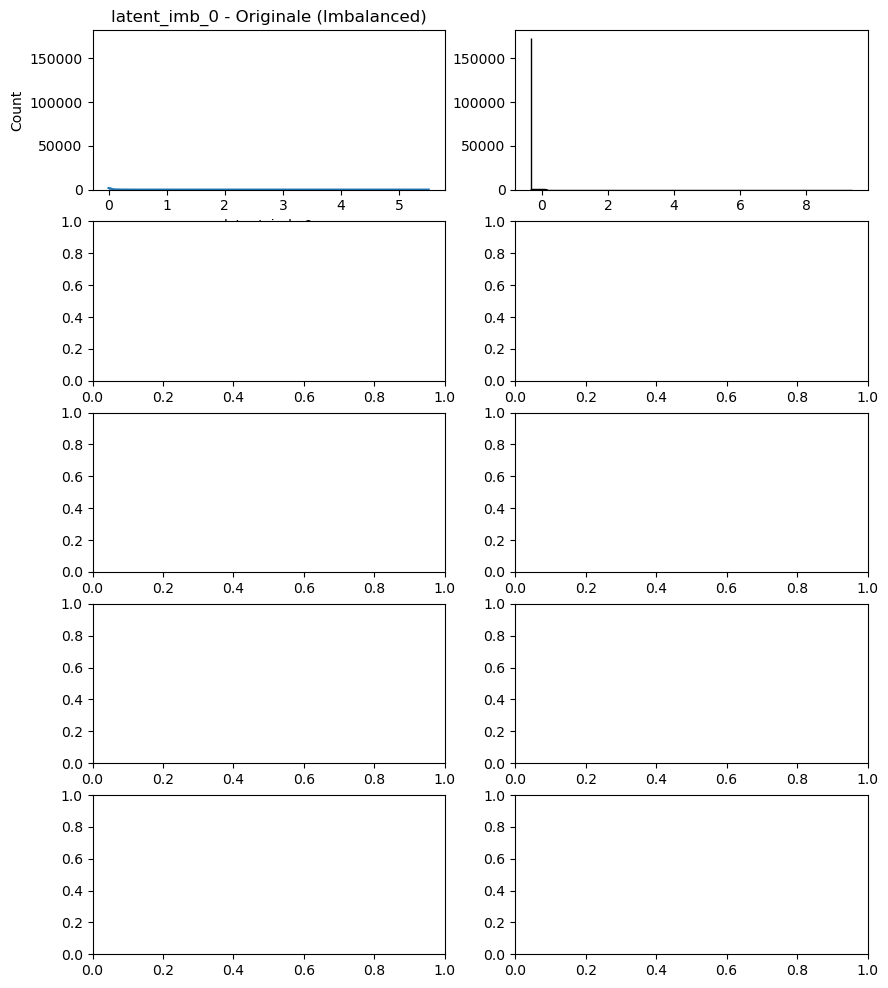

In [ ]:
# ==========================================================
# BLOCCO 8b (Imbalanced): Train/Test Split + Scaling + Analisi distribuzioni
# ==========================================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("🏗️ Suddivisione IMBALANCED dataset in train/test e analisi bilanciamento classi...")

# 1️⃣ Split stratificato
X_train_imb, X_test_imb, y_train_imb, y_test_imb = train_test_split(
    X_classifier_imb,
    y_classifier_imb,
    test_size=0.2,
    stratify=y_classifier_imb,
    random_state=42
)

print("✅ Split completato (Imbalanced).")
print(f"Train: {X_train_imb.shape}, Test: {X_test_imb.shape}")

# 2️⃣ Percentuali per categoria
train_dist_imb = y_train_imb.value_counts(normalize=True) * 100
test_dist_imb = y_test_imb.value_counts(normalize=True) * 100

print("\n📊 Distribuzione classi nel TRAIN (Imbalanced):")
print(train_dist_imb.round(2))
print("\n📊 Distribuzione classi nel TEST (Imbalanced):")
print(test_dist_imb.round(2))

# 3️⃣ Grafico distribuzione classi
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(x=train_dist_imb.index, y=train_dist_imb.values, ax=axes[0])
axes[0].set_title("Distribuzione classi - Train (Imbalanced)")
sns.barplot(x=test_dist_imb.index, y=test_dist_imb.values, ax=axes[1])
axes[1].set_title("Distribuzione classi - Test (Imbalanced)")
plt.tight_layout()
plt.show()

# 4️⃣ Scaling
print("\n⚙️ Applicazione StandardScaler sugli embeddings latenti (Imbalanced)...")
scaler_latent_imb = StandardScaler()
X_train_imb_scaled = pd.DataFrame(scaler_latent_imb.fit_transform(X_train_imb), columns=X_train_imb.columns)
X_test_imb_scaled = pd.DataFrame(scaler_latent_imb.transform(X_test_imb), columns=X_test_imb.columns)
print("✅ Scaling completato (Imbalanced).")

# 5️⃣ Visualizzazione confronto pre/post scaling
sample_features_imb = X_train_imb.columns[:5]
fig, axes = plt.subplots(len(sample_features_imb), 2, figsize=(10, 12))
for i, feat in enumerate(sample_features_imb):
    sns.histplot(X_train_imb[feat], ax=axes[i, 0], kde=True)
    axes[i, 0].set_title(f"{feat} - Originale (Imbalanced)")
    sns.histplot(X_train_imb_scaled[feat], ax=axes[i, 1], kde=True)
    axes[i, 1].set_title(f"{feat} - Scaled (Imbalanced)")
plt.tight_layout()
plt.show()

print(f"\n✅ Dataset IMBALANCED pronto per classificazione multiclasse.")
print(f"Train: {X_train_imb_scaled.shape}, Test: {X_test_imb_scaled.shape}")


In [ ]:
# ==========================================================
# BLOCCO 9a: Salvataggio dataset, scaler e encoder
# ==========================================================
import joblib
import os

print("💾 Salvataggio dati e oggetti per training...")

# Crea cartella di output se non esiste
os.makedirs("model_data", exist_ok=True)

# 1️⃣ Salvataggio dataset train/test
X_train_scaled.to_csv("model_data/X_train_balanced.csv", index=False)
X_test_scaled.to_csv("model_data/X_test_balanced.csv", index=False)
y_train.to_csv("model_data/y_train_balanced.csv", index=False)
y_test.to_csv("model_data/y_test_balanced.csv", index=False)

print("✅ Dataset salvati in 'model_data/'")

# 2️⃣ Salvataggio StandardScaler
joblib.dump(scaler_latent, "model_data/scaler_latent.pkl")
print("✅ Scaler salvato come 'scaler_latent.pkl'")

print("\n🎯 Tutti i dati pronti per l'addestramento dei modelli multiclasse!")


💾 Salvataggio dati e oggetti per training...
✅ Dataset salvati in 'model_data/'
✅ Scaler salvato come 'scaler_latent.pkl'
✅ Encoder salvato come 'encoder_best.keras'

🎯 Tutti i dati pronti per l'addestramento dei modelli multiclasse!


In [ ]:
# ==========================================================
# BLOCCO 9b Imbalanced: Salvataggio dataset, scaler e encoder
# ==========================================================
import joblib
import os

print("💾 Salvataggio dati e modelli IMBALANCED...")

# 1️⃣ Creazione cartella di output
os.makedirs("model_data_imbalanced", exist_ok=True)

# 2️⃣ Salvataggio dataset train/test
X_train_imb_scaled.to_csv("model_data_imbalanced/X_train_imb.csv", index=False)
X_test_imb_scaled.to_csv("model_data_imbalanced/X_test_imb.csv", index=False)
y_train_imb.to_csv("model_data_imbalanced/y_train_imb.csv", index=False)
y_test_imb.to_csv("model_data_imbalanced/y_test_imb.csv", index=False)
print("✅ Dataset IMBALANCED salvati in 'model_data_imbalanced/'")

# 3️⃣ Salvataggio scaler
joblib.dump(scaler_latent_imb, "model_data_imbalanced/scaler_latent_imb.pkl")
print("✅ Scaler IMBALANCED salvato come 'scaler_latent_imb.pkl'")

# 4️⃣ Salvataggio encoder (dall’autoencoder imbalanced)
encoder_imb.save("model_data_imbalanced/encoder_imb_best.keras")
print("✅ Encoder IMBALANCED salvato come 'encoder_imb_best.keras'")

print("\n🎯 Tutti i dati e modelli IMBALANCED pronti per il training!")


💾 Salvataggio dati e modelli IMBALANCED...
✅ Dataset IMBALANCED salvati in 'model_data_imbalanced/'
✅ Scaler IMBALANCED salvato come 'scaler_latent_imb.pkl'
✅ Encoder IMBALANCED salvato come 'encoder_imb_best.keras'

🎯 Tutti i dati e modelli IMBALANCED pronti per il training!
